# Image RAG with CLIP


## 1. Download Wikipedia Images


In [1]:
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

from pathlib import Path
IMAGE_PATH = Path("images")

In [3]:
import wikipedia
import urllib.request
from pathlib import Path

image_uuid = 0
image_metadata_dict = {}
MAX_IMAGES_PER_WIKI = 30

wiki_titles = [
    "Salesforce",
    "Tesla",
    "Cluade Monet", 
    "San Francisco",
    "Violin", 
    "Mount Fuji",
    "iPhone"
]

if not IMAGE_PATH.exists():
    Path.mkdir(IMAGE_PATH)

In [4]:
for title in wiki_titles:
    images_per_wiki = 0
    print(title)
    try:
        page_py = wikipedia.page(title)
        list_img_urls = page_py.images
        for url in list_img_urls:
            if url.endswith(".jpg") or url.endswith(".png"):
                image_uuid += 1
                image_file_name = title + "_" + url.split("/")[-1]

                # img_path could be s3 path pointing to the raw image file in the future
                image_metadata_dict[image_uuid] = {
                    "filename": image_file_name,
                    "img_path": "./" + str(IMAGE_PATH / f"{image_uuid}.jpg"),
                }
                urllib.request.urlretrieve(
                    url, IMAGE_PATH / f"{image_uuid}.jpg"
                )
                images_per_wiki += 1
                # Limit the number of images downloaded per wiki page to 15
                if images_per_wiki > MAX_IMAGES_PER_WIKI:
                    break
    except:
        continue

Salesforce
Tesla
Cluade Monet
San Francisco
Violin
Mount Fuji
iPhone


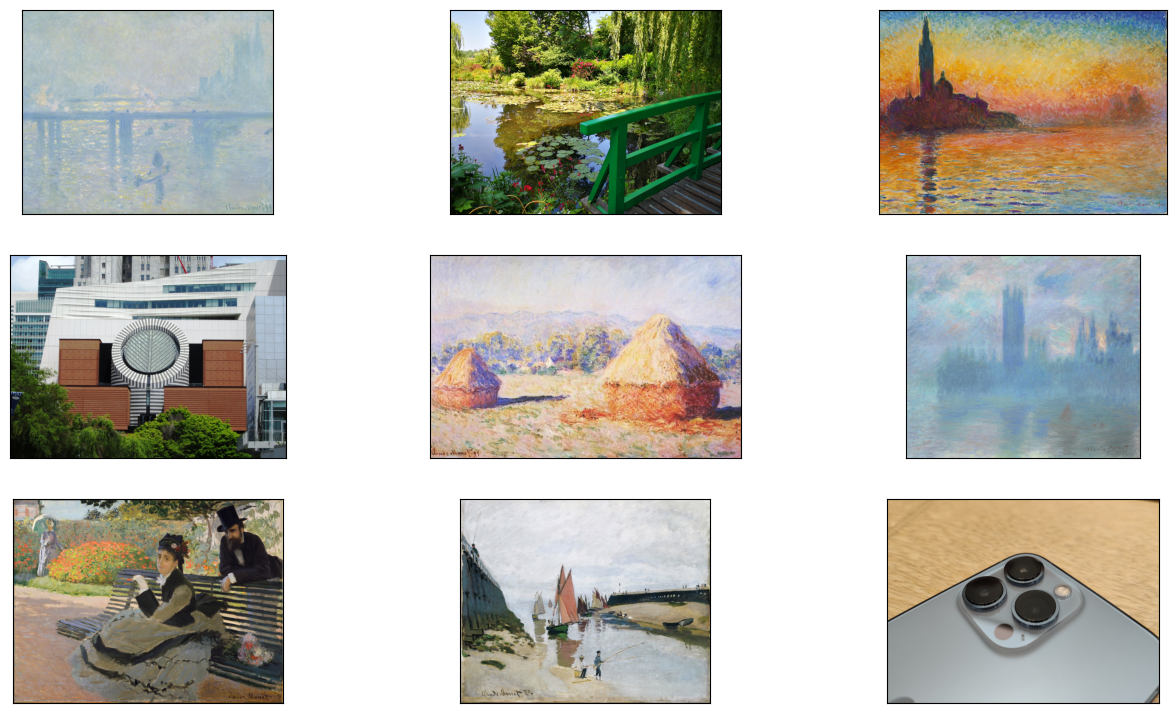

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
import os

image_paths = []
for img_path in os.listdir(IMAGE_PATH):
    image_paths.append(str(os.path.join(IMAGE_PATH, img_path)))


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(3, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break

plot_images(image_paths)

## Build Multi-Modal Index


In [6]:
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import SimpleDirectoryReader, StorageContext

import qdrant_client
from llama_index.core import SimpleDirectoryReader

# do a search on "local docker qdrant install"
TEXT_COLLECTION_NAME = "wiki_text"
IMAGE_COLLECTION_NAME = "wiki_image"
DEFAULT_QDRANT_PORT = "6333"
QDRANT_URL = "http://localhost:6333" 
# os.environ.get("QDRANT_LOCAL_URL")
QDRANT_API_KEY = os.environ.get("QDRANT_API_KEY")
q_client = qdrant_client.QdrantClient(url=QDRANT_URL, port=DEFAULT_QDRANT_PORT)

In [7]:
text_store = QdrantVectorStore(
    collection_name=TEXT_COLLECTION_NAME,
    client=q_client, 
    enable_hybrid=False
)
image_store = QdrantVectorStore(
    client=q_client, collection_name=IMAGE_COLLECTION_NAME
)
storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)
# Create the MultiModal index
documents = SimpleDirectoryReader(IMAGE_PATH).load_data()
index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
)

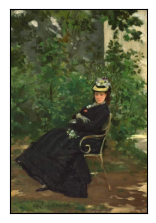

In [13]:
input_image = "./images/5.jpg"
plot_images([input_image])


## RAG with a Multi-Modal Index


Let's use an image to image query engine to search for similar images


In [14]:
retriever_engine = index.as_retriever(image_similarity_top_k=4)
retrieval_results = retriever_engine.image_to_image_retrieve(
    "./images/5.jpg"
)

retrieved_images = []
for res in retrieval_results:
    retrieved_images.append(res.node.metadata["file_path"])

len(retrieved_images)

4

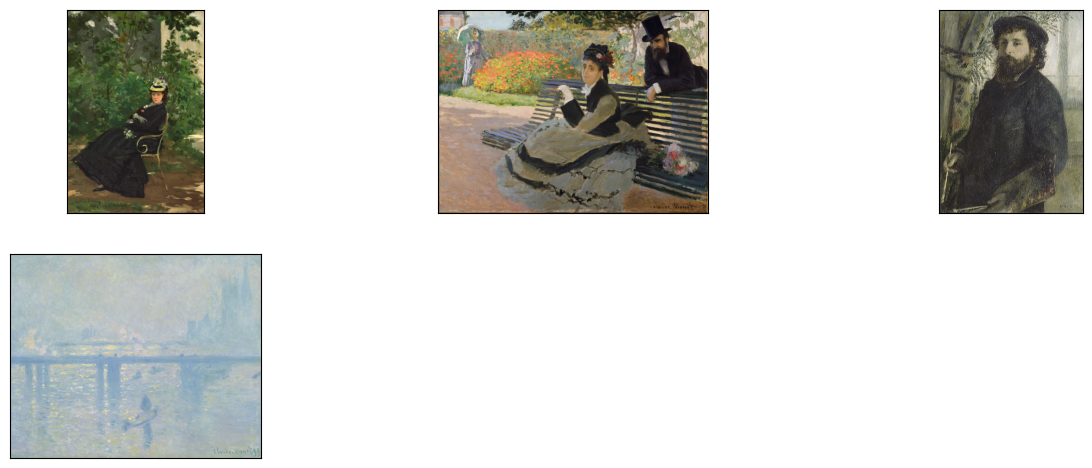

In [15]:
plot_images(retrieved_images)

## Find Descriptions of Related Images


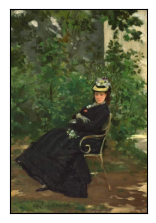

In [16]:
input_image = "./images/5.jpg"
plot_images([input_image])

In [17]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from llama_index.core import SimpleDirectoryReader
from llama_index.core.schema import ImageDocument

image_documents = [ImageDocument(image_path=input_image)]

for res_img in retrieved_images[1:]:
    image_documents.append(ImageDocument(image_path=res_img))

openai_mm_llm = OpenAIMultiModal(
    model="gpt-4o", api_key=os.environ.get("OPENAI_API_KEY"), max_new_tokens=1500
)
response = openai_mm_llm.complete(
    prompt="Given the first image as the base image, what the other images correspond to?",
    image_documents=image_documents,
)

print(response)

The first image is a painting by Édouard Manet titled "In the Garden" (1870). The other images correspond to:

1. The second image is "Camille Monet on a Garden Bench" by Claude Monet, depicting a similar garden setting with figures.
2. The third image is a portrait of Claude Monet by Pierre-Auguste Renoir, showing the artist himself.
3. The fourth image is "Waterloo Bridge, Sunlight Effect" by Claude Monet, showcasing his impressionist style with a focus on light and atmosphere.

These images are related through their impressionist style and the artists' connections.


## Create an Image Search Engine


In [18]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from llama_index.core import PromptTemplate
qa_tmpl_str = (
    "Given the images provided, "
    "answer the query.\n"
    "Query: {query_str}\n"
    "Answer: "
)
qa_tmpl = PromptTemplate(qa_tmpl_str)
openai_mm_llm = OpenAIMultiModal(
    model="gpt-4o", api_key=os.environ.get("OPENAI_API_KEY"), max_new_tokens=1500
)
query_engine = index.as_query_engine(
    llm=openai_mm_llm, image_qa_template=qa_tmpl
)


In [20]:
def image_qa(query_str: str, image_path: str):
    response = query_engine.image_query(image_path, query_str)
    return response

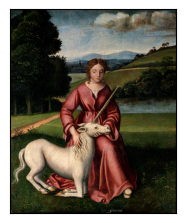

In [22]:
input_image = "./images/18.jpg"
plot_images([input_image])

In [23]:
response = image_qa("Please describe the image in detail.", "./images/18.jpg")
print(response.response)

The first image depicts a serene scene featuring a woman in a flowing red gown sitting in a lush, green landscape. She is gently holding a unicorn, which is resting beside her. The background includes rolling hills, trees, and a body of water, with a partly cloudy sky above.

The second image is a portrait of a bearded man wearing a dark coat and a hat. He is holding paintbrushes and a palette, suggesting he is an artist. The background is softly lit, with hints of foliage and a window, creating a calm and introspective atmosphere.
